<a href="https://colab.research.google.com/github/vpste1/mlscrapbook/blob/master/MultiCategory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 12.7MB/s 
     |████████████████████████████████| 1.1MB 19.9MB/s 
     |████████████████████████████████| 194kB 54.1MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
Mounted at /content/gdrive


In [3]:
#hide
from fastbook import *

In [4]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

# Constructing a DataLoader from scratch:

## The DataFrame (Pandas)

Use *Pandas* tp visualise the data. Pandas is a Python library that is used to manipulate and alayze tabular and time series data. It's main class is `DataFrame`, which represents a table of rows and columns loaded from a CSV, DB table, Python dict, etc. 

In [5]:
df = pd.read_csv(path/'train.csv')
df

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True
...,...,...,...
5006,009954.jpg,horse person,True
5007,009955.jpg,boat,True
5008,009958.jpg,person bicycle,True
5009,009959.jpg,car,False


Using the Dataframe's `iloc` property, you can access specific rows/columns:

In [6]:
df.iloc[:,1]

0                chair
1                  car
2         horse person
3                  car
4              bicycle
             ...      
5006      horse person
5007              boat
5008    person bicycle
5009               car
5010               dog
Name: labels, Length: 5011, dtype: object

In [7]:
df.iloc[1]

fname       000007.jpg
labels             car
is_valid          True
Name: 1, dtype: object

It's also possible to grab a specific column by name:

In [8]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

Creating DataFrames is easy from scratch:

In [9]:
tmp_df = pd.DataFrame({'a': [1,2], 'b': [6,8]})
tmp_df

,a,b
0,1,6
1,2,8


Can also do calculations using columns:

In [10]:
tmp_df['c'] = tmp_df['a'] + tmp_df['b']
tmp_df

,a,b,c
0,1,6,7
1,2,8,10


## Datasets, DataLoaders and DataBlocks

Quick recap on definitions:

- `Dataset`:: A collection that returns a tuple of your independent and dependent variable for a single item
- `DataLoader`:: An iterator that provides a stream of mini-batches, where each mini-batch is a tuple of a batch of independent variables and a batch of dependent variables

On top of these, fastai provides two classes for bringing your training and validation sets together:

- `Datasets`:: An object that contains a training `Dataset` and a validation `Dataset`
- `DataLoaders`:: An object that contains a training `DataLoader` and a validation `DataLoader`

Since a `DataLoader` builds on top of a `Dataset` and adds additional functionality to it (collating multiple items into a mini-batch), it’s often easiest to start by creating and testing `Datasets`, and then look at `DataLoaders` after that’s working.

A `DataBlock` is generic container used to build both `Dataset` and `DataLoader`. They can be built gradually so that we can check any errors as we go: 

In [11]:
dblock = DataBlock()

A `Datasets` object can be built from this empty `DataBlock`, the only thing required is the source of data (in our case the `DataFrame`):

In [12]:
dsets = dblock.datasets(df)

Since `dsets` is an object of type `Datasets`, it has both the validation and training `Dataset` accessible:

In [13]:
len(dsets.train),len(dsets.valid)

(4009, 1002)

As mentioned before, a `Dataset` is a list of tuples, each item with the independent and dependent variables:

In [14]:
x,y = dsets.train[0]
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object, fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In the above snippet, you can see that x and y are identical (they are the same row of the `DataFrame`). This is because the data block assumes we have two things: input and target. We need to specify the fields we want with the `get_x` and `get_y` functions:

In [15]:
x['fname']

'008663.jpg'

Let's redefine the `dblock` with the correct `get_x` and `get_y` functions:

In [16]:
dblock = DataBlock(get_x= lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

Whilst `lambda` functions are great for quick iterations; they are not serialised (saved). They are good for prototyping/experimenting, but it's better to be more verbose if intending to export your work.

So far we are getting the filename, but not the location; and the labels should be represented as a list (not a space-delimited string):

In [17]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/002549.jpg'), ['tvmonitor'])

The path to the image is not the actual image itself, it needs to be opened. Defining `ImageBlock` as the independent variable will do this for us.

For the dependent variables (labels) we have used `CategoryBlock` in the past, which returned a single integer pointing to what category it belonged to. Now that we are dealing with potentially multiple categories per image, we need to use `MultiCategoryBlock` which uses one-hot encoding (a vector of zeros, with ones in the location of each category that the image belongs to).  

In [18]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock), 
                   get_x = get_x,
                   get_y = get_y)
dsets = dblock.datasets(df)
x,y = dsets.train[0]
x,y

(PILImage mode=RGB size=500x325,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]))

We can also define how to split the dataset (using a `splitter`) into both valid and training data. Our dataframe specifies an `is_valid` key: 

In [19]:
# Both `train` and `valid` are lists of indices

def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                    splitter = splitter,
                   get_x = get_x,
                   get_y = get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

The last step before creating out `DataLoaders` is to ensure that every item is of the same size. This canbe done with a `RandomResizedCrop`: 

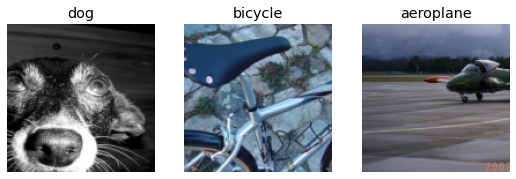

In [20]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                  splitter=splitter,
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

dls.show_batch(nrows=1, ncols =3)

Important to remember that if anything goes wrong with making your `DataLoaders` from your `DataBlock` you can use the `summary` method to help diagnose and troubleshoot.

# Binary Cross-Entropy

To begin to create our `Learner` we need to build a suitable loss function. We can quickly create a `Learner` from `cnn_learner` to view its activations:

In [21]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


We can grab a single batch from the `DataLoader` we built earlier (64 images), and input them into the pretrained model to receive the activations for those images (in each of the 20 potential cateogries): 

In [22]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

Here are what the predictions look like for one of the images: 

In [23]:
activs[0]

tensor([ 0.4153,  1.2974, -2.9310,  1.3063, -0.6814, -1.7772,  0.8123, -0.4988, -1.6027,  1.3562,  1.2609,  0.0103,  2.3019, -0.4606, -0.4662,  0.6359, -3.2023, -0.8144, -3.8843, -0.8441],
       grad_fn=<SelectBackward>)

Making use of the `sigmoid` function, we can spread these between 0 and 1. Additionally making use of the log function, we can calculate the loss:

In [26]:
activs.sigmoid().shape

torch.Size([64, 20])

In [29]:
def binary_cross_entropy(inputs, targets):
  inputs = inputs.sigmoid()
  return -torch.where(target == 1, 1 - inputs, inputs).log().mean()


Previously we have made use of `nll_loss` and `softmax` which aren't applicable here.

`softmax` requires the predictions to sum to 1, and pushes one activation to be much higher than the others using the exponent. In this usecase, there may be scenarios where none of the categories are present, so we wouldn't want the probabilities of the categories to add to 1 (summing to 1 implies we want one of the categories to exist). 

`nll_loss` returns the value of just one activation; since we are dealing with potentially multiple labels it doesn't make sense to use it.

Making use of our `binary_cross_entropy` (which is just our `mnist_loss` combined with `log`) provides use with what we need due to to the ability to do elementwise operations with broadcasting.

As with all our previous creations from scratch, PyTorch already provides this functionality:

>`F.binary_cross_entropy` / `nn.BCELoss` calculate cross-entropy on a one-hot-encoded target, but do not include the initial `sigmoid`. This means that normally you will what `F.binary_cross_entropy_with_logits` (or `nn.BCEWithLogitsLoss`) which include `sigmoid` into the single function.

In [30]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0954, grad_fn=<AliasBackward>)

We don't actually need to tell fastai to use this loss function (although we can if we want) since it will be automatically chosen for us. fastai knows that the `DataLoaders` has multiple category labels, so it will use `nn.BCEWithLogitsLoss` by default.

In terms of metrics, we previously used a function that would determine accuracy based on which activation was the highest, and checking its index against the target's index. With multiple categories, this won't work.

For multiple categories, we want to look at the activations and pick a threshold for what we determine the activation to be predicting that category; compare the old with the new:

```python
#Old accuracy
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred = inp.argmax(dim=axis)
    return (pred == targ).float().mean()
```

```python
#New accuracy
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()
```

When we pass `accuracy_multi` directly to the learner as the metric function, it will make use of the default threshold when determining accuracy. If we want to be able to tweak that threshold, we would make a different version of `accuracy_multi` that has a different threshold. 

Python can facilitate this making use of `partial` functions. It allows us to bind a function with some arguments set, making a new version of that function, e.g:

In [31]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.933915,0.709149,0.233147,00:32
1,0.814584,0.558509,0.282948,00:32
2,0.595266,0.207797,0.797530,00:31
3,0.357321,0.122629,0.942231,00:31


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.131946,0.118102,0.938845,00:32
1,0.116592,0.108786,0.953566,00:32
2,0.096613,0.104919,0.949920,00:32


Determining a threshold will have a great bearing on accuracy, so it's not a decision to overlook. We can get the predictions from the tuned mode like so: 

In [34]:
preds,targs = learn.get_preds()
preds

tensor([[3.6148e-03, 8.6071e-03, 2.4516e-03,  ..., 5.0311e-01, 2.4414e-03, 1.4455e-01],
        [5.0900e-05, 1.4474e-03, 5.2500e-04,  ..., 2.3942e-03, 1.8724e-04, 3.9535e-05],
        [4.6572e-04, 2.0935e-02, 3.4996e-03,  ..., 2.1355e-03, 2.0243e-04, 1.0819e-03],
        ...,
        [2.1466e-03, 3.6746e-03, 3.5647e-04,  ..., 9.6336e-03, 2.9814e-03, 3.7324e-03],
        [1.1829e-02, 1.3949e-02, 2.0893e-02,  ..., 3.9153e-03, 8.9634e-03, 3.9586e-03],
        [8.4489e-04, 8.8587e-01, 2.8629e-03,  ..., 2.9575e-03, 7.5817e-04, 5.1528e-03]])

The following technique can be used to identify a good threshold to pick when operating the learner: (note: `get_preds` applies the output activation function by default for us, so we won't need to apply it later when finding our optimal

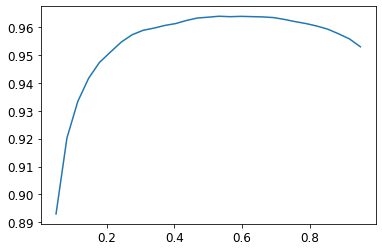

In [35]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

This is a good example of using the validation set to pick a **hyperparameter** (the threshold). 